# Plot COCO Dataset ground truth images

This code is me combining different code that I found for my own learning. Credit to these repositories that I used to create the following notebook.

- [albumentations](https://github.com/albu/albumentations)
- [cocoapi](https://github.com/cocodataset/cocoapi)
- [cv2 output RGB blog](https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_matplotlib_rgb_brg_image_load_display_save.php)

The COCO dataset must be dowloaded to use this notebook [val2014](http://images.cocodataset.org/zips/val2014.zip) and the [annotations](http://images.cocodataset.org/annotations/annotations_trainval2014.zip). The code expects these two directory downloads to live in `~/data/coco`


In [1]:
import json
import os

import numpy as np
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

plt.ion()
pylab.rcParams['figure.figsize'] = 12, 12

In [2]:
def load_json(path):
    "Loads JSON as a Python object from a given file path"
    with open(path) as f:
        data = json.loads(f.read())
    return data

def get_imageid_to_imageann():
    return {x['id']: x for x in ANN['images']}

In [3]:
HOME_DIR = os.path.expanduser('~')
DATA_DIR = os.path.join(HOME_DIR, 'data/coco/val2014/')
ANN_DIR = os.path.join(HOME_DIR, 'data/coco/annotations/')

ANN = load_json(os.path.join(ANN_DIR, 'instances_val2014.json'))
IMAGEID_TO_IMAGEANN = get_imageid_to_imageann()
CATEGORY_ID_TO_NAME = {x['id']: x['name'] for x in ANN['categories']}

In [4]:
ANN.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [5]:
len(ANN['images']), len(ANN['annotations'])

(40504, 291875)

In [6]:
len(IMAGEID_TO_IMAGEANN)

40504

In [7]:
def get_imageid_to_anns(ann_path=None, ann=None):
    """
    Returns a dict where the key is an imageid and the value
    is a list of annotations for that image
    """
    if not any([ann_path, ann]) or all([ann_path, ann]):
        raise AssertionError("can only use 1 kwarg")

    if not ann:
        ann = load_json(ann_path)

    imageid_to_anns = {}
    for img in ann['images']:
        imageid_to_anns[img['id']] = []

    for a in ann['annotations']:
        imageid_to_anns[a['image_id']].append(a)

    return imageid_to_anns

IMAGEID_TO_ANN = get_imageid_to_anns(ann=ANN)

assert len(IMAGEID_TO_ANN) == len(ANN['images'])

len(IMAGEID_TO_ANN)

40504

In [8]:
# validate!

In [9]:
ann_count = 0
for imageid, annot in IMAGEID_TO_ANN.items():
    ann_count += len(annot)
    
assert ann_count == len(ANN['annotations'])

ann_count

291875

In [10]:
len(ANN['images']), len(ANN['annotations'])

(40504, 291875)

In [11]:
image_id, img_ann = next(iter(IMAGEID_TO_IMAGEANN.items()))
image_id, img_ann

(391895,
 {'license': 3,
  'file_name': 'COCO_val2014_000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895})

In [12]:
import cv2
import os

def open_image(image_path):
    """
    Returns an image as a rgb np.ndarray
    """
    bgr_img = cv2.imread(image_path)
    # get b,g,r
    b,g,r = cv2.split(bgr_img)
    # switch it to rgb
    return cv2.merge([r,g,b])

image_path = os.path.join(DATA_DIR, img_ann['file_name'])
image = open_image(image_path)
image.shape

(360, 640, 3)

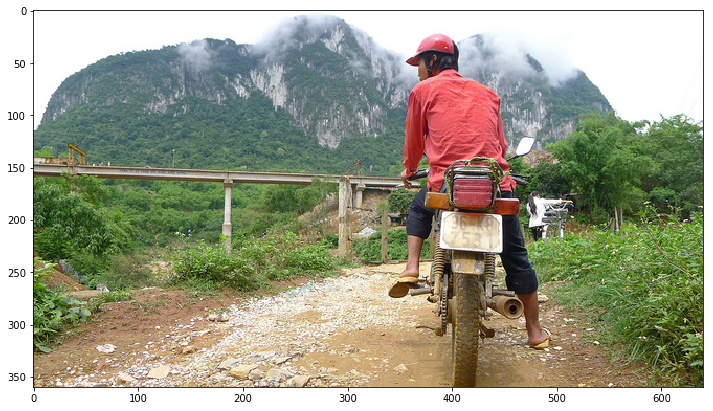

In [13]:
pylab.rcParams['figure.figsize'] = 12, 12

def show_img(image):
    plt.imshow(image)
    
show_img(image)

## plot bboxes!

In [14]:
image_id

391895

In [15]:
len(IMAGEID_TO_ANN[image_id])

4

In [16]:
IMAGEID_TO_ANN[image_id][0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

In [17]:
bboxes = [x['bbox'] for x in IMAGEID_TO_ANN[image_id]]
bboxes

[[359.17, 146.17, 112.45, 213.57],
 [339.88, 22.16, 153.88, 300.73],
 [471.64, 172.82, 35.92, 48.1],
 [486.01, 183.31, 30.63, 34.98]]

In [18]:
category_ids = [x['category_id'] for x in IMAGEID_TO_ANN[image_id]]
category_ids

[4, 1, 1, 2]

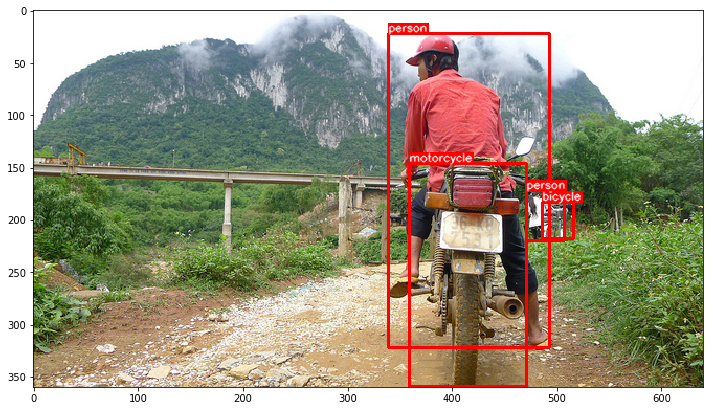

In [19]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img, class_name, (x_min, y_min - int(0.3 * text_height)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    
annotations = {
    'image': image, 
    'bboxes': bboxes,
    'category_id': category_ids
}

visualize(annotations, CATEGORY_ID_TO_NAME)

## plot masks!

In [20]:
seg = IMAGEID_TO_ANN[image_id][0]['segmentation'][0]
poly = np.array(seg).reshape((int(len(seg)/2), 2))
poly

array([[376.97, 176.91],
       [398.81, 176.91],
       [396.38, 147.78],
       [447.35, 146.17],
       [448.16, 172.05],
       [448.16, 178.53],
       [464.34, 186.62],
       [464.34, 192.28],
       [448.97, 195.51],
       [447.35, 235.96],
       [441.69, 258.62],
       [454.63, 268.32],
       [462.72, 276.41],
       [471.62, 290.98],
       [456.25, 298.26],
       [439.26, 292.59],
       [431.98, 308.77],
       [442.49, 313.63],
       [436.02, 316.86],
       [429.55, 322.53],
       [419.84, 354.89],
       [402.04, 359.74],
       [401.24, 312.82],
       [370.49, 303.92],
       [391.53, 299.87],
       [391.53, 280.46],
       [385.06, 278.84],
       [381.01, 278.84],
       [359.17, 269.13],
       [373.73, 261.85],
       [374.54, 256.19],
       [378.58, 231.11],
       [383.44, 205.22],
       [385.87, 192.28],
       [373.73, 184.19]])

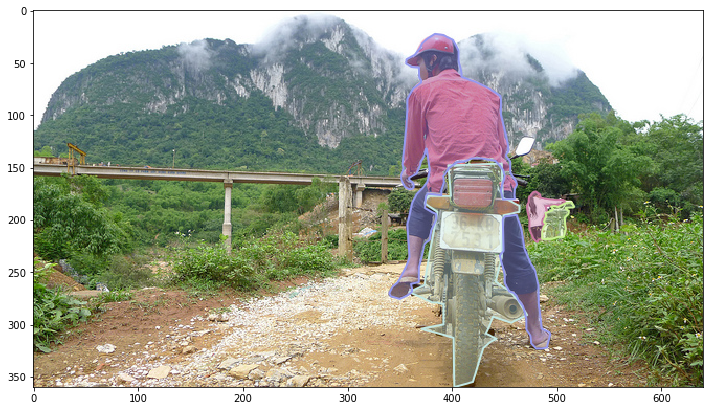

In [21]:
# bbox
show_img(image)

ax = plt.gca()
polygons = []
color = []
anns = IMAGEID_TO_ANN[image_id]
for ann in anns:
    c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]

    # polygon
    for seg in ann['segmentation']:
        poly = np.array(seg).reshape((int(len(seg)/2), 2))
        polygons.append(Polygon(poly))
        color.append(c)

p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
ax.add_collection(p)
p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
ax.add_collection(p)

## put it all together!

In [22]:
IMAGE_IDS = list(IMAGEID_TO_IMAGEANN.keys())

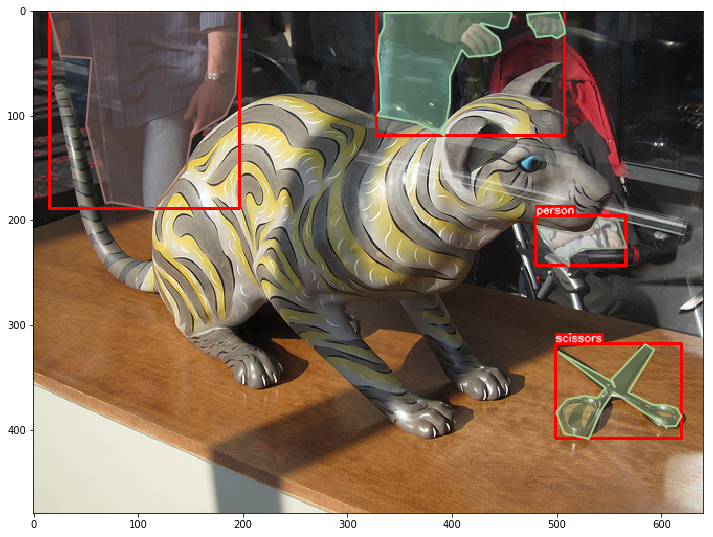

In [23]:
def plot_bboxes_and_masks():
    image_id = np.random.choice(IMAGE_IDS)
    image_ann = IMAGEID_TO_IMAGEANN[image_id]
    image_path = os.path.join(DATA_DIR, image_ann['file_name'])
    image = open_image(image_path)

    # image + bboxes
    bboxes = [x['bbox'] for x in IMAGEID_TO_ANN[image_id]]
    category_ids = [x['category_id'] for x in IMAGEID_TO_ANN[image_id]]
    annotations = {
        'image': image, 
        'bboxes': bboxes,
        'category_id': category_ids
    }
    visualize(annotations, CATEGORY_ID_TO_NAME)

    ax = plt.gca()
    polygons = []
    color = []
    anns = IMAGEID_TO_ANN[image_id]
    for ann in anns:
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        # polygon
        for seg in ann['segmentation']:
            poly = np.array(seg).reshape((int(len(seg)/2), 2))
            polygons.append(Polygon(poly))
            color.append(c)

    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)
    
plot_bboxes_and_masks()

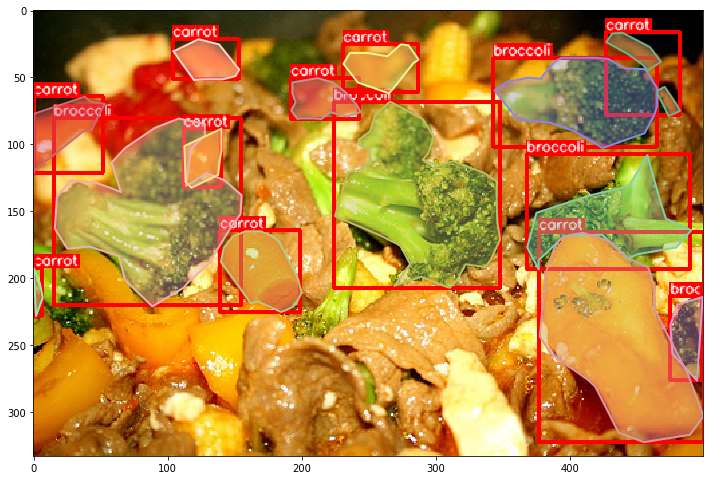

In [25]:
plot_bboxes_and_masks()

## review dataset format

In [26]:
ANN.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [27]:
ANN['images'][0]

{'license': 3,
 'file_name': 'COCO_val2014_000000391895.jpg',
 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-14 11:18:45',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'id': 391895}

In [29]:
ANN['annotations'][0]

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

# Plot my own labeled data

Note: this data format is using **RectLabel**. From what I can tell, it doesn't export `"segmentation"`
data to the same format as COCO Dataset 2014 that I'm using, so I'm going to use **Labelme** instead
I think

In [32]:
CAR_ANN = load_json('/Users/aaron/Desktop/license_plate_detection/annotations/annotations.json')

In [35]:
car_img = open_image('/Users/aaron/Desktop/license_plate_detection/images/1.jpg')
car_img.shape

(450, 600, 3)

In [37]:
# show_img(car_img)

In [39]:
CAR_ANN.keys()

dict_keys(['images', 'annotations', 'categories'])

In [41]:
len(CAR_ANN['annotations']), type(CAR_ANN['annotations'])

(26, list)

In [42]:
import collections

imageid_to_imageann = collections.defaultdict(lambda: [])
for x in CAR_ANN['annotations']:
    imageid_to_imageann[x['image_id']].append(x)

In [43]:
image_id = 1
imageid_to_imageann[image_id]

[{'area': 98280,
  'segmentation': {'size': [450, 600],
   'counts': 'kZY2j;n60000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000eoU1'},
  'iscrowd': 0,
  'image_id': 1,
  'bbox': [99, 125, 378, 260],
  'category_id': 1,
  'id': 1},
 {'area': 3696,
  'segmentation': {'size': [450, 600],
   'counts': 'k]_5d2T`00000000000000000000000000000000000000000000000000000000000000000000000000000000000000e^n1'},
  'iscrowd': 0,
  'image_id': 1,
  'bbox': [243, 299, 84, 44],
  'category_id': 2,
  'id': 2}]

In [45]:
bboxes = [x['bbox'] for x in imageid_to_imageann[image_id]]
bboxes

[[99, 125, 378, 260], [243, 299, 84, 44]]

In [50]:
category_ids = [x['category_id'] for x in imageid_to_imageann[image_id]]
category_ids

[1, 2]

In [51]:
image = car_img

In [52]:
category_id_to_name = {
    1: 'car',
    2: 'plate'
}

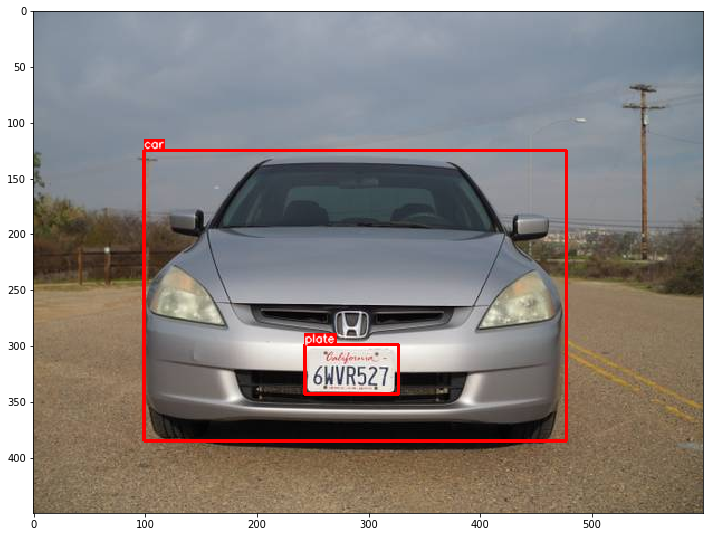

In [53]:
annotations = {
    'image': image, 
    'bboxes': bboxes,
    'category_id': category_ids
}

visualize(annotations, category_id_to_name)